 <p style = "font-size: 34px;font-weight: bold;text-align:center;color:#800000"> Ecosure Violations vs Foot-traffic </p>

<div>
    <img src = "http://upload.wikimedia.org/wikipedia/en/0/0c/Mu_Sigma_Logo.jpg" align="left" style="height:100px;margin-right:100px">
</div>
<div>
    <img src = "https://upload.wikimedia.org/wikipedia/commons/2/26/Ecolab.svg" align="right" style="height:40px;margin-left:100px; margin-top:25px">
</div>

<p style="font-size:100%;text-align:left;font-weight:bold"> Created by  : Mu Sigma team for Ecolab
<p style="font-size:100%;text-align:left;font-weight:bold;"> Last edited : 05/27/2021

 <p style = "font-size: 20px;font-weight: bold;text-align: left;color:#000000"> Description:   </p>
 
This notebook is used to explore the relationship between foot-traffic and ecosure violations.  <br>

Data Used: <br>
* <b>Normalized Foot traffic data</b>, across different the brands Modern Market 
* <b>Ecosure Violations data</b>, across different the brands Modern Market and 

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
import os
import json
import pickle 
import pandas as pd
import numpy as np
import warnings
import itertools
import requests
import datetime
import matplotlib
import seaborn as sns
import pytz
import pyodbc

from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from itertools import product
from fuzzywuzzy import fuzz
from pandas.io.json import json_normalize
from scipy import stats

utc=pytz.UTC
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 2000)
pd.options.display.float_format = '{:.4f}'.format

In [4]:
def correlation_matrix(var, df, title):
    
    # Compute the correlation matrix
    corr_data = df[var]
    sns.set(style="white")
    corr = corr_data.corr()
    corr = corr.round(2)
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 150, n=9)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
                annot = True, vmin=-1)

    ax.set_title(title, fontsize=32)
    plt.show()
    

def spearman_corr(df_datagrouped, test_var, measure):
    '''
    This functions returns a table with spearman hypothesis
    test results
    '''
    spearman_corr = []
    null_hypothesis = []
    alternate_hypothsesis = []
    p_val = []
    
    corr, pval = spearmanr(df_datagrouped[test_var],
                            df_datagrouped[measure])
        
    spearman_corr.append(corr)
    p_val.append(pval)
        
    # Accpeted and Rejected interchanged
    if pval < 0.10:
        null_hypothesis.append('Rejected')
        alternate_hypothsesis.append('Accepted')
    else:
        null_hypothesis.append('Accepted')
        alternate_hypothsesis.append('Rejected')

    test_df = pd.DataFrame({'Spearman Coefficient': spearman_corr,
                            'p-value': p_val,
                            'Null Hypothesis': null_hypothesis,
                            'Atlernate Hypothesis': alternate_hypothsesis})
    
    return test_df

In [5]:
######################################################### Audit Data ###################################################################
########################################################################################################################################

df_audit = pd.read_csv('./csv/EcosureAudits80.csv')

# Aggregating data at month year level
df_audit['AuditStarted'] = pd.to_datetime(df_audit['AuditStarted'], errors='coerce')
df_audit['Date'] = df_audit['AuditStarted'].dt.date
df_audit['month_year'] = df_audit['Date'].apply(lambda x: x.strftime('%B-%Y'))

df_violations = df_audit.groupby(['month_year', 'ClientName'], as_index=False).agg({'Level1_Violations' : 'sum', 'Level2_Violations' : 'sum',
                                                                                    'Level3_Violations' : 'sum', 'Score' : 'mean', 
                                                                                    'ClientID' : 'count'})

# Renaming Columns
df_violations.rename({'Level1_Violations' : 'Minor_Violations', 
                      'Level2_Violations' : 'Major_Violations',
                      'Level3_Violations' : 'Critical_Violations',
                      'Score' : 'Mean_Audit_Score',
                      'ClientName' : 'Brand',
                      'ClientID' : 'No_of_Audits'},axis=1, inplace=True)

# Adding KPIs
df_violations['Total_No_of_Violations'] = df_violations['Minor_Violations'] + df_violations['Major_Violations'] + df_violations['Critical_Violations']

# Adding Normalized KPIs
df_violations['Minor_Violations_per_audit'] = df_violations['Minor_Violations']/df_violations['No_of_Audits']
df_violations['Major_Violations_per_audit'] = df_violations['Major_Violations']/df_violations['No_of_Audits']
df_violations['Critical_Violations_per_audit'] = df_violations['Critical_Violations']/df_violations['No_of_Audits']
df_violations['Total_No_of_Violations_per_audit'] = df_violations['Total_No_of_Violations']/df_violations['No_of_Audits']

# filter for brands to be analyzed
df_violations = df_violations[(df_violations.Brand=='Modern Market') | (df_violations.Brand=='Texas Roadhouse')]
df_violations.reset_index(drop=True, inplace=True)

In [6]:
# Reading Datasets normalized foot traffic data
df_normalstore = pd.read_csv('/User/csv/Normalized_store_visit_data.csv')

# Aggregating data at month year level
df_normalstore['date'] = pd.to_datetime(df_normalstore['date'], errors='coerce', format='%m/%d/%Y')
df_normalstore['Date'] = df_normalstore['date'].dt.date
df_normalstore['month_year'] = df_normalstore['Date'].apply(lambda x: x.strftime('%B-%Y'))

df_normalstore_month = df_normalstore.groupby(['month_year', 'location_brand'], as_index=False).agg({'trips_normalized' : 'mean'})
df_normalstore_month.rename({'location_brand' : 'Brand'}, axis=1, inplace=True)

dict_mapping = {'ModernMarket' : 'Modern Market',
                'TexasRoadhouse' : 'Texas Roadhouse'}

df_normalstore_month['Brand'] = df_normalstore_month['Brand'].map(dict_mapping)

In [7]:
df_merged = pd.merge(df_normalstore_month, df_violations, how='inner', on=['month_year', 'Brand'])

# Ordering by month
new_orders = ['January-2020', 'February-2020', 'March-2020', 'April-2020', 'May-2020', 'June-2020', 'July-2020', 'August-2020',
              'September-2020', 'October-2020', 'November-2020', 'December-2020','January-2021', 'February-2021', 'March-2021', 'April-2021']

df_merged['month_year'] = pd.Categorical(df_merged['month_year'], categories=new_orders, ordered=True)
df_merged.sort_values(by=['month_year'], ascending=True, inplace=True)
df_merged = df_merged[df_merged.month_year.notnull()]
df_merged.reset_index(drop=True, inplace=True)

# Approach 1: Overall Brand Analysis

## Descriptive Analysis 

Key Message-
* <b>High Violations per Audit</b> seems have <b>less number of Normalized Trip Visits</b>
* <b>High Mean Audit Score</b> seems have <b>high number of Normalized Trip Visits</b>

### Violations/Audit vs Normalized Trips (visits) Distribution acrosss brands

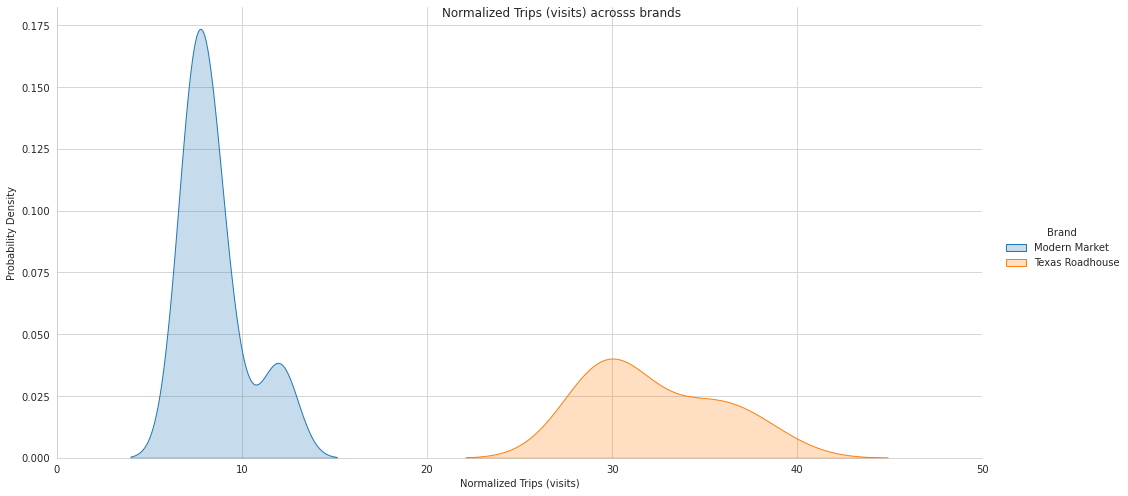

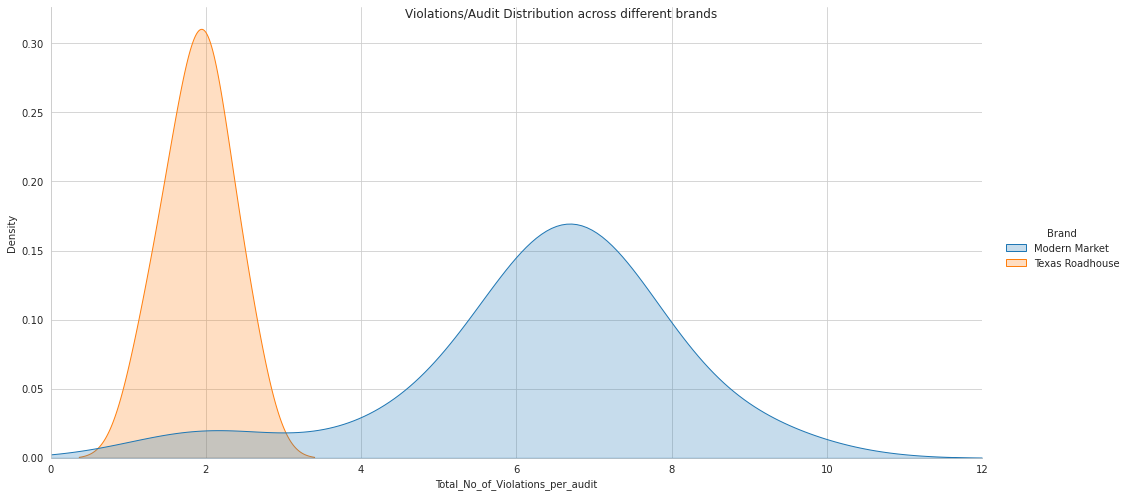

In [8]:
sns.set_style("whitegrid")
ax = sns.displot(data=df_merged, x='trips_normalized', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(0,50))
ax.set(xlabel = 'Normalized Trips (visits)', ylabel = 'Probability Density')
ax.fig.suptitle("Normalized Trips (visits) acrosss brands",
                  fontsize=12, fontdict={"weight": "bold"})


ax = sns.displot(data=df_merged, x='Total_No_of_Violations_per_audit', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(0,12))
ax.fig.suptitle("Violations/Audit Distribution across different brands",
                  fontsize=12, fontdict={"weight": "bold"})
plt.show()

Finding : 
* For the brand <b>Texas Roadhouse</b>, the distribution has <b>high # of normalized trip visits and low no of violations per audit</b>
* For the brand <b>Modern Market</b>, the distribution has <b>low # of normalized trip visits and high no of violations per audit</b>

### Violations per Audit across Normalized Trip (visits)

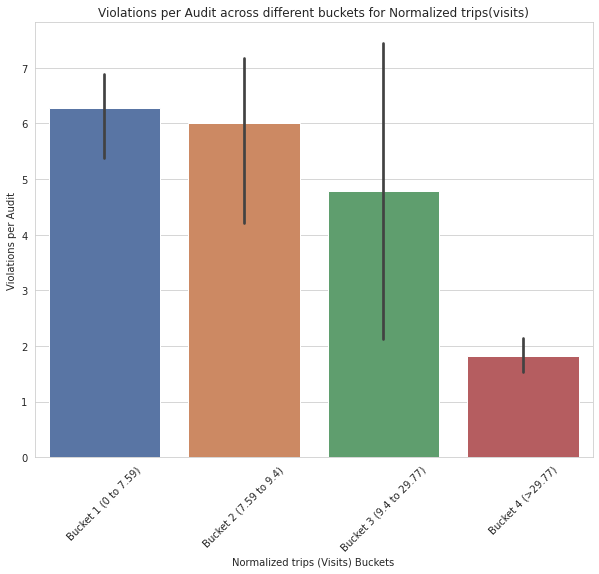

In [9]:
def req_intervals(x):
    if (x > 0) & (x < 7.59):
        return 'Bucket 1 (0 to 7.59)'
    elif (x >= 7.59) & (x < 9.4):
        return 'Bucket 2 (7.59 to 9.4)'
    elif (x >= 9.4) &  (x < 29.77):
        return 'Bucket 3 (9.4 to 29.77)'
    else:
        return 'Bucket 4 (>29.77)'
    
df_dist_1 = df_merged.copy(deep=True)
df_dist_1['Violations_per_audit'] = df_dist_1['Total_No_of_Violations_per_audit']
df_dist_1['Metric Buckets'] = df_dist_1['trips_normalized'].apply(req_intervals)

orders = ['Bucket 1 (0 to 7.59)', 'Bucket 2 (7.59 to 9.4)', 'Bucket 3 (9.4 to 29.77)', 'Bucket 4 (>29.77)']

plt.figure(figsize=(10,8))
ax = sns.barplot(x='Metric Buckets', y='Violations_per_audit', data=df_dist_1, palette = 'deep', order=orders)
ax.set(xlabel = 'Normalized trips (Visits) Buckets', ylabel = 'Violations per Audit')
ax.set_title('Violations per Audit across different buckets for Normalized trips(visits)')
plt.xticks(rotation=45)
plt.show()

### Mean Audit Scores across Normalized Trip (visits)

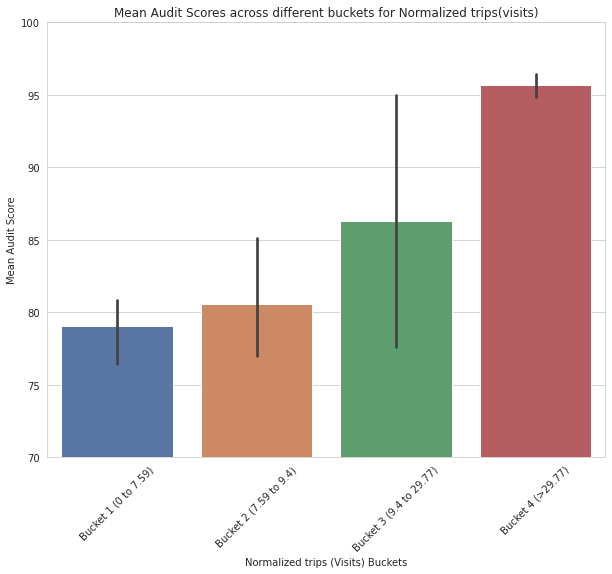

In [10]:
def req_intervals(x):
    if (x > 0) & (x < 7.59):
        return 'Bucket 1 (0 to 7.59)'
    elif (x >= 7.59) & (x < 9.4):
        return 'Bucket 2 (7.59 to 9.4)'
    elif (x >= 9.4) &  (x < 29.77):
        return 'Bucket 3 (9.4 to 29.77)'
    else:
        return 'Bucket 4 (>29.77)'
    
df_dist_1 = df_merged.copy(deep=True)
df_dist_1['Mean_Audit_Score'] = df_dist_1['Mean_Audit_Score']
df_dist_1['Metric Buckets'] = df_dist_1['trips_normalized'].apply(req_intervals)

orders = ['Bucket 1 (0 to 7.59)', 'Bucket 2 (7.59 to 9.4)', 'Bucket 3 (9.4 to 29.77)', 'Bucket 4 (>29.77)']

plt.figure(figsize=(10,8))
ax = sns.barplot(x='Metric Buckets', y='Mean_Audit_Score', data=df_dist_1, palette = 'deep', order=orders)
ax.set(xlabel = 'Normalized trips (Visits) Buckets', ylabel = 'Mean Audit Score')
ax.set_title('Mean Audit Scores across different buckets for Normalized trips(visits)')
plt.xticks(rotation=45)
plt.ylim(70, 100)
plt.show()

# Approach 2: Across Brands 

##  Correlation Matrix

### Data Aggregated at Month-Year & Brand Level

In [15]:
df_mod_market = df_merged[df_merged.Brand=='Modern Market']
df_mod_market["trips_normalized_lag"] = df_mod_market["trips_normalized"].shift(1)
df_mod_market["trips_normalized_lead"] = df_mod_market["trips_normalized"].shift(-1)

df_tx = df_merged[df_merged.Brand=='Texas Roadhouse']
df_tx["trips_normalized_lag"] = df_tx["trips_normalized"].shift(1)
df_tx["trips_normalized_lead"] = df_tx["trips_normalized"].shift(-1)

df_merged_1 = df_mod_market.append(df_tx)
df_merged_1.reset_index(drop=True, inplace=True)

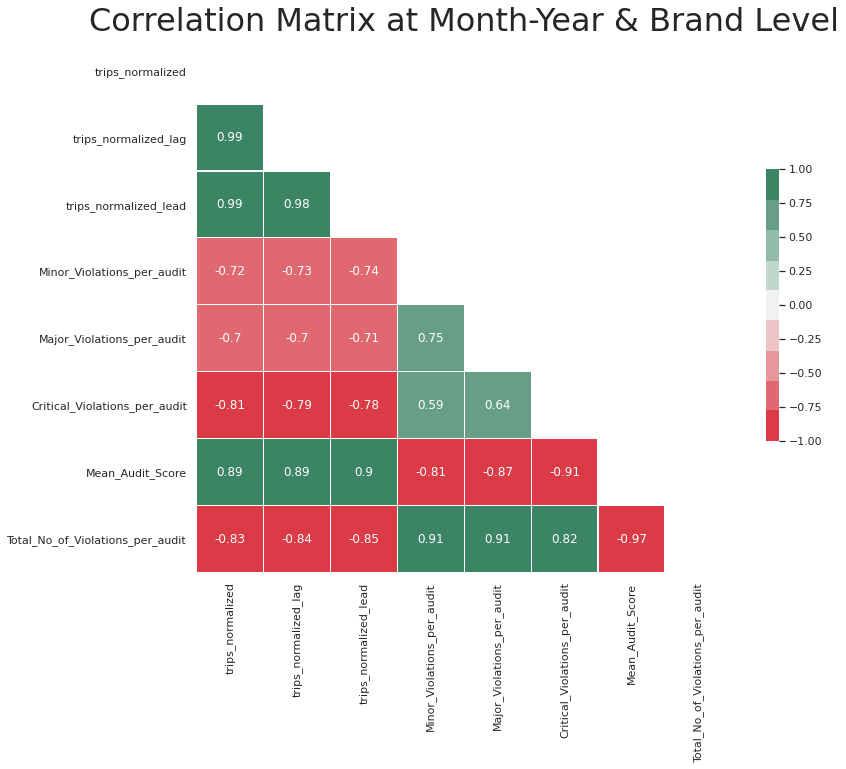

Total number of data Points:  21


In [18]:
var = ['trips_normalized', 'trips_normalized_lag', 'trips_normalized_lead', 'Minor_Violations_per_audit', 'Major_Violations_per_audit', 'Critical_Violations_per_audit', 'Mean_Audit_Score',
       'Total_No_of_Violations_per_audit']

correlation_matrix(var, df_merged_1, "Correlation Matrix at Month-Year & Brand Level")
print('Total number of data Points: ', len(df_merged_1))

There seems to be a very high negative correlation between Violations per Audit and trips normalized per store (-.83). <br>
<b>(This might indicate, High # of violations per Audit might lead to less # of trips normalized per store) </b> <br>
Also, there seems to a very high positive correlation between Mean Audit Score and trips normalized per store (.89). <br>
<b>(This might indicate, High Mean Audit Score might lead to high # of trips normalized per store) </b> <br>

## Hypothesis Testing

Results-
* <b>Increase in Violations per Audit, results in decreased Normalized trips (visits) </b>

### Hypothesis 1: Violations per Audit vs Normalized trips (visits)
<br>
<b>Null Hypothesis:</b> Increase in Violations per Audit does not affect Normalized trips (visits)
 
<b>Alternate Hypothesis:</b> Increase in Violations per Audit, results in decreased Normalized trips (visits)

In [19]:
spearman_corr(df_merged, 'Total_No_of_Violations_per_audit', 'trips_normalized')

,Spearman Coefficient,p-value,Null Hypothesis,Atlernate Hypothesis
0,-0.6465,0.0015,Rejected,Accepted


### Hypothesis 2: Mean Audit Score vs Normalized trips (visits)
<br>
<b>Null Hypothesis:</b> Increase in Audit Scores does not affect Normalized trips (visits)
 
<b>Alternate Hypothesis:</b> Increase in Audit Scores, results in increase in Normalized trips(visits)

In [20]:
spearman_corr(df_merged, 'Mean_Audit_Score', 'trips_normalized')

,Spearman Coefficient,p-value,Null Hypothesis,Atlernate Hypothesis
0,0.7182,0.0002,Rejected,Accepted
